# 3.2 Transforming Variables

In this section, we will transform and combine existing variables to obtain new variables. Our examples are drawn from a data set of house prices in Ames, Iowa.  This data set is stored in a tab-separated values file.  For more information about the variables in this data set, please refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt).

In [1]:
import pandas as pd

data_dir = "https://dlsun.github.io/pods/data/"
df_ames = pd.read_csv(data_dir + "AmesHousing.txt", sep="\t")
df_ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Applying Transformations

### Quantitative Variables

There are several reasons to transform quantitative variables, including:

1. to change the measurement units
2. to make the variable more amenable to analysis

As an example of the first reason, suppose we want the lot areas to be in acres instead of square feet. Since there are 43560 square feet in an acre, this requires dividing each lot area by 43560. We can **broadcast** the division over the entire `Series`.

In [2]:
df_ames["Lot Area"] / 43560

0       0.729339
1       0.266804
2       0.327525
3       0.256198
4       0.317493
          ...   
2925    0.182208
2926    0.203972
2927    0.239692
2928    0.229798
2929    0.221006
Name: Lot Area, Length: 2930, dtype: float64

If we want to store the results as a new variable in the `DataFrame`, we simply assign the `Series` to a new column in the `DataFrame`. The command below does two things: creates a new column in the `DataFrame` called "Lot Area (acres)" _and_ populates it with the values from the `Series` above.

In [3]:
df_ames["Lot Area (acres)"] = df_ames["Lot Area"] / 43560

The second reason for transforming quantitative variables is to make them more amenable to analysis. To see why a variable might not be amenable to analysis, let's take a look at a histogram of lot areas.

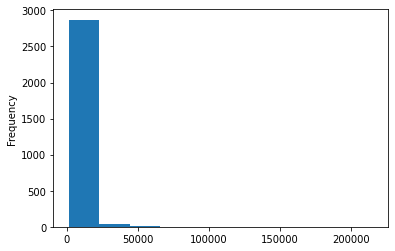

In [4]:
df_ames["Lot Area"].plot.hist()

There are a few homes with such extreme lot areas that we get virtually no resolution at the lower end of the distribution. Over 95% of the observations are in a single bin of this histogram. In other words, this variable is extremely _skewed_.

One way to improve this histogram is to use more bins. But this does not solve the fundamental problem: we need more resolution at the lower end of the scale and less resolution at the higher end. One way to spread out the values at the lower end of a distribution and to compress the values at the higher end is to take the logarithm (provided that the values are all positive). Log transformations are particularly effective at dealing with data that is skewed to the right.

The log function is not built into Python or `pandas`. We have to import the log function from a library called `numpy`, which contains many functions and data structures for numerical computations. In fact, `pandas` is built on top of `numpy`. When we apply `numpy`'s `log` function to a `pandas` `Series`, the function is automatically broadcast over the elements of the `Series`, returning another `Series`. Let's save the results to a variable called "log(Lot Area)".

In [5]:
import numpy as np
df_ames["log(Lot Area)"] = np.log(df_ames["Lot Area"])
df_ames["log(Lot Area)"]

0       10.366278
1        9.360655
2        9.565704
3        9.320091
4        9.534595
          ...    
2925     8.979291
2926     9.092120
2927     9.253496
2928     9.211340
2929     9.172327
Name: log(Lot Area), Length: 2930, dtype: float64

These numbers are not very interpretable on their own, but if we make a histogram of these values, we see that the lower end of the distribution is now more spread out, and the extreme values are not so extreme anymore.

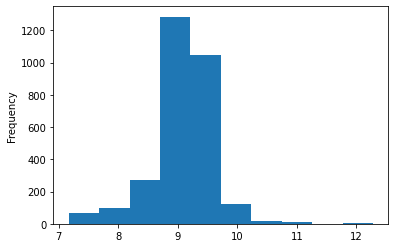

In [6]:
df_ames["log(Lot Area)"].plot.hist()

It is possible for a log transformation to overcorrect for skew. For example, the "SalePrice" variable is also right-skewed.

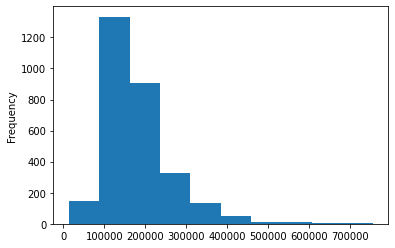

In [7]:
df_ames["SalePrice"].plot.hist()

But if we take logs, the distribution becomes somewhat left-skewed.

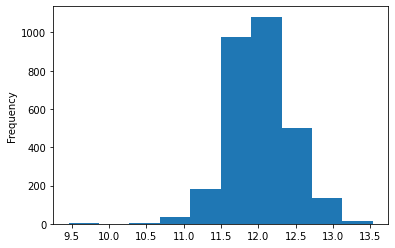

In [8]:
np.log(df_ames["SalePrice"]).plot.hist()

Is there a transformation that makes the resulting distribution more symmetric?

In fact, log is just one transformation in a whole family of transformations. Because the transformations in this family involve raising the values to some power, the statistician John Tukey called this the **ladder of powers**:

$$ x(\lambda) = \begin{cases} x^\lambda & \lambda > 0 \\  \log(x) & \lambda = 0 \\ -x^\lambda & \lambda < 0 \end{cases} $$

$\lambda = 1$ corresponds to no transformation at all. As we decrease $\lambda$, the distribution becomes more left-skewed (which is useful when the original distribution is right-skewed). Since log ($\lambda = 0$) was an overcorrection, let's back off and increase $\lambda$:

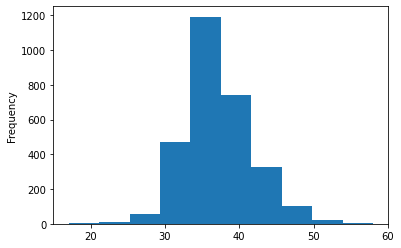

In [9]:
(df_ames["SalePrice"] ** .3).plot.hist()

This seems to be better. We can move $\lambda$ up and down the ladder until the distribution is the shape we want.

### Why $\lambda = 0$ corresponds to $\log$ (Optional)

You might have noticed that it does not make sense to use the transformation $x^0$ for $\lambda = 0$, since anything raised to the zero power equals 1. But why is $\log(x)$ the right function to replace $x^0$?

The answer has to do with calculus. We want to understand the behavior of $x^\lambda$ as $\lambda$ approaches 0. To do this properly, we actually need to consider the function

$$\frac{x^\lambda - 1}{\lambda}.$$

Subtracting 1 and dividing by $\lambda$ are just constants that shift and scale the distribution; they do not affect the overall shape of the distribution. Therefore, the histogram of $x^\lambda$ will look the same as the histogram of $(x^\lambda - 1) / \lambda$; only the axes will be different.

Using calculus, you can show that the limit of the above function as $\lambda$ approaches 0 is:

$$\lim_{\lambda \to 0} \frac{x^\lambda - 1}{\lambda} = \log(x).$$

(Challenge: prove this!) This is why it makes sense to slot $\log(x)$ in for $x^0$.

### Other Mathematical Functions in Numpy (Optional)

You might wonder what other mathematical functions are available in `numpy` besides `log`. For one, there is `log10`, which implements the base-10 logarithm. (By default, `np.log` is the natural logarithm, base-$e$.) 

[Here is an exhaustive list of the mathematical functions](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.math.html). All of these functions are compatible with `pandas`.

## Combining Variables

We can also create new variables out of multiple existing variables. For example, in the current data set, the information about when a house was sold is spread across two variables, "Yr Sold" and "Mo Sold" (1-12 indicating the month). We can combine these two variables into one, by dividing the month the house was sold by 12 and then adding that to the year. So for example, this new variable would equal 2010.5 if the house was sold in June 2010 and 2006.75 if it was sold in September 2006.

In [10]:
df_ames["Date Sold"] = df_ames["Yr Sold"] + df_ames["Mo Sold"] / 12
df_ames["Date Sold"]

0       2010.416667
1       2010.500000
2       2010.500000
3       2010.333333
4       2010.250000
           ...     
2925    2006.250000
2926    2006.500000
2927    2006.583333
2928    2006.333333
2929    2006.916667
Name: Date Sold, Length: 2930, dtype: float64

Notice how division by 12 is _broadcast_ over the elements of the `Series` `df_ames["Mo Sold"]` to produce a new `Series`. The resulting `Series` is then added to `df_ames["Yr Sold"]`. The addition here is _elementwise_. This is an example of another feature of `pandas` and `numpy` called **vectorization**. In general, arithmetic operations between two `Series` (or two `DataFrame`s) are applied elementwise, resulting in a `Series` (or `DataFrame`) of the same shape. 

This property is called _vectorization_ because it mimics the way vectors work in math. For example, to add two vectors, we add each component separately:

$$ {\bf v} + {\bf w} = \begin{pmatrix} v_1 \\ \vdots \\ v_n \end{pmatrix} + \begin{pmatrix} w_1 \\ \vdots \\ w_n \end{pmatrix} = \begin{pmatrix} v_1 + w_1 \\ \vdots \\ v_n + w_n \end{pmatrix}, $$

which is exactly how `Series` addition works. The analogy is not perfect; for example, we are allowed to divide two `Series` elementwise, which comes in handy if we want to calculate a per-unit metric (like cost per square foot):

In [11]:
df_ames["Cost per Sq Ft"] = df_ames["SalePrice"] / df_ames["Gr Liv Area"]
df_ames["Cost per Sq Ft"]

0       129.830918
1       117.187500
2       129.420617
3       115.639810
4       116.574586
           ...    
2925    142.073779
2926    145.232816
2927    136.082474
2928    122.390209
2929     94.000000
Name: Cost per Sq Ft, Length: 2930, dtype: float64

However, in math, division of two vectors is not defined.

$$ {\bf v}\ /\ {\bf w} =\ ? $$

# Exercises

Exercise 1 deals with the Ames housing data set in this lesson. Refer to the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt) if you have any trouble finding or understanding a variable in this data set.

1\. The number of bathrooms is typically reported as a decimal to allow for half bathrooms (i.e., bathrooms without a shower). In this data set, the number of full bathrooms and the number of half bathrooms are separate variables. Add a new column to the `DataFrame` that stores the total number of bathrooms in each home.

In [15]:
df_ames["Total Bath"] = df_ames["Full Bath"] + df_ames["Half Bath"] / 2
df_ames["Total Bath"]

0       1.0
1       1.0
2       1.5
3       2.5
4       2.5
       ... 
2925    1.0
2926    1.0
2927    1.0
2928    1.0
2929    2.5
Name: Total Bath, Length: 2930, dtype: float64

Exercises 2-4 deal with the Tips data set (`https://dlsun.github.io/pods/data/tips.csv`).

In [16]:
data_dir = "https://dlsun.github.io/pods/data/"
df_tips = pd.read_csv(data_dir + "tips.csv")
df_tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


2\. Create a new column, **tip_percent**, that stores the tip as a percentage of the total bill.

In [18]:
df_tips["tip_percent"] = df_tips["tip"] / df_tips["total_bill"] * 100
df_tips["tip_percent"]

0       5.944673
1      16.054159
2      16.658734
3      13.978041
4      14.680765
         ...    
239    20.392697
240     7.358352
241     8.822232
242     9.820426
243    15.974441
Name: tip_percent, Length: 244, dtype: float64

3\. Make a visualization that shows the distribution of the total bills. Transform the variable first so that it is approximately symmetric.

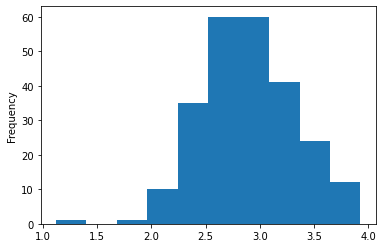

In [26]:
df_tips["log(total_bill)"] = np.log(df_tips["total_bill"])
df_tips["log(total_bill)"].plot.hist()

4\. Suppose the total bill + tip are divided evenly among the people in each party. Which table paid the most _per person_?

In [ ]:
df_tips["per_person"] = (df_tips["total_bill"] + df_tips["tip"]) / df_tips["size"]
df_tips[df_tips["per_person"] == df_tips["per_person"].max()]

**Table 184 paid the most per person.**